<h1>ITEC 6740 Final Project</h1>

<h3>Company News Article Sentiment Analysis</h3>

<p>Based off tutorial here: https://www.youtube.com/watch?v=o-zM8onpQZY</p>

In [52]:
# Import necessary libraries

from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
# Finviz url where news articles are pulled from
finviz_url = "https://finviz.com/quote.ashx?t="

# Tickers appended to the url each corresponding to an organization
tickers =["AMZN", "GOOGL", "AAPL"]

# All the news articles are located in a table with id 'news-table'
# Store this information in a dictionary
news_tables = {}

# loop through the tickers, construct the urls, pull the news tables
for ticker in tickers:
    # construct the url and create the request
    url = finviz_url + ticker
    req = Request(url=url, headers={'user-agent': 'my-app'})
    # open the request
    response = urlopen(req)
    
    # parse the html response
    html = BeautifulSoup(response, 'html')

    # find the news table object
    news_table = html.find(id="news-table")
    # store it in the dictionary with the appropriate ticker as the key
    news_tables[ticker] = news_table

In [54]:
# Parse the tables to retrieve relevant information

# List to store the parsed data
parsed_data = []

# Iterate through the dictionary of news tables
for ticker, news_table in news_tables.items():
    # Retrieve the text and date data from the news tables by parsing table rows
    for row in news_table.findAll('tr'):
        title = row.a.get_text()
        # date has two parts: day and time separated by a space
        date_data = row.td.text.split(" ")

        # If there is an occurence where there is only a time
        if len(date_data) == 1:
            time = date_data[0]
        # Otherwise, there is both a date and time
        else:
            date = date_data[0]
            time = date_data[1]

        parsed_data.append([ticker, date, time, title])

In [55]:
# convert parsed_data to a data frame
df = pd.DataFrame(parsed_data, columns=["ticker", "date", "time", "title"])

# intialize vader sentiment analysis
vader = SentimentIntensityAnalyzer()

# function to calculate the polarity scores for every title, only interested in the compound score
f = lambda title: vader.polarity_scores(title)["compound"]

# store the compound polarity scores in a new column called 'compound'
# apply the function to every title in the dataframe
df["compound"] = df["title"].apply(f)

# convert the date column to datetime objects
df["date"] = pd.to_datetime(df.date).dt.date

                   compound
ticker date                
AAPL   2021-07-14  0.157976
       2021-07-15  0.043181
       2021-07-16  0.032548
       2021-07-17  0.100475
       2021-07-18  0.000000
       2021-07-19  0.150160
AMZN   2021-07-14  0.171612
       2021-07-15  0.178868
       2021-07-16  0.033050
       2021-07-17  0.147733
       2021-07-18  0.028377
       2021-07-19  0.139595
GOOGL  2021-07-12 -0.028063
       2021-07-13 -0.035419
       2021-07-14  0.017127
       2021-07-15 -0.079687
       2021-07-16  0.021653
       2021-07-17  0.035575
       2021-07-18 -0.052000
       2021-07-19  0.057162
         compound                                                         \
date   2021-07-12 2021-07-13 2021-07-14 2021-07-15 2021-07-16 2021-07-17   
ticker                                                                     
AAPL          NaN        NaN   0.157976   0.043181   0.032548   0.100475   
AMZN          NaN        NaN   0.171612   0.178868   0.033050   0.147733   
GOOG

<Figure size 720x576 with 0 Axes>

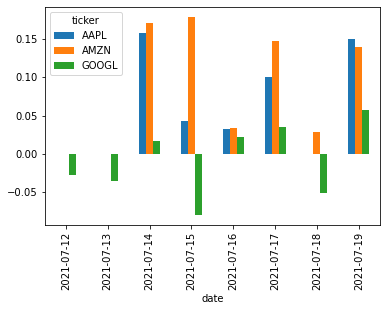

In [58]:
# visualize sentiment analysis

# set figure size
plt.figure(figsize=(10,8))

# create a new dataframe grouped by ticker and date with mean compound scores calculated
mean_df = df.groupby(["ticker", "date"]).mean()

# basically makes the dates column labels, each date has a mean compound score
mean_df = mean_df.unstack()

# removes the compound column left over by the unstack
mean_df = mean_df.xs("compound", axis="columns").transpose()

# create a bar plot and show it
mean_df.plot(kind="bar")
plt.show()